# Hands-on Advanced Deep Learning Time Series Forecasting with Tensors

# Medium Time-Series

In [1]:
#!sudo yum install graphviz -y

In [2]:
#!pip install pydot
#!pip install graphviz

In [3]:
#!pip uninstall -y keras tensorflow

In [4]:
#!pip install keras==2.8.0 tensorflow==2.8.0

In [5]:
#!pip install statsmodels

In [6]:
#!pip install keras-mdn-layer
#!pip install tensorflow_probability

In [7]:
#!pip install keras_multi_head
#!pip install keras-self-attention
#!pip install keras-tcn

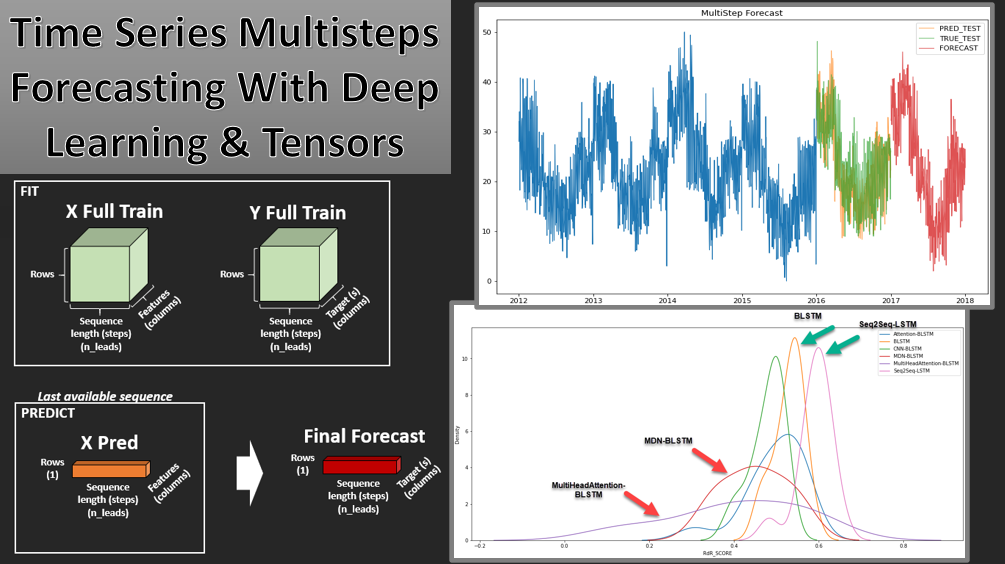

In [8]:
from IPython.display import Image
Image(filename='/opt/continuum/data/image/cover.png')

How can we forecast long-term multi-steps into the futur using deep learning models and tensors ? This article will deep dive this question using 3 different time series and a diversity of neural network architectures.

You will learn how to convert a dataframe time serie to a 3d tensor and then, how to forecasts multiple steps into the future while validating the results.

At the end of this article, there is a link to the notebook used as well as the time series csv files.

Enjoy!

 <a class="anchor" id="menu"></a>
# Table of content:

### [Section#1 - Data](#P1)
[1.1 Loading the Time Series](#section1.1)<br/>
[1.2 Exploring the Time Series](#section1.2)<br/>
        
### [Section#2 - Feature Engineering](#P2)
[2.1 Train-Test Split Scale](#section2.1)<br/>
[2.2 Feature Extraction - Seasonal Means](#section2.2)<br/>
[2.3 Feature Extraction - Lagged Values](#section2.3)<br/>
[2.4 Feature Extraction - Fourier terms](#section2.4)<br/>
[2.5 Final dataset - Merge all features + Differenciation, Seasonality, Trend](#section2.5)<br/>

### [Section#3 - From 2D Matrice to 3D Tensor](#P3)
[3.1 3D Train-Test set](#section3.1)<br/>
[3.2 3D Forecast set](#section3.2)<br/>

### [Section#4 - RdR Score Performance Metric](#P4)

### [Section#5 - BiLSTM](#P5)
[5.1 BiLSTM Architecture](#section5.1)<br/>
[5.2 BiLSTM Training](#section5.2)<br/>
[5.3 BiLSTM Validation](#section5.3)<br/>
[5.4 BiLSTM Forecasting](#section5.4)<br/>

### [Section#6 - Time2Vec-BiLSTM](#P6)
[6.1 Time2Vec-BiLSTM Architecture](#section6.1)<br/>
[6.2 Time2Vec-BiLSTM Training](#section6.2)<br/>
[6.3 Time2Vec-BiLSTM Validation](#section6.3)<br/>
[6.4 Time2Vec-BiLSTM Forecasting](#section6.4)<br/>


In [9]:
with open('seed_increment.txt') as f:
    lines = f.readlines()

increment = int(lines[0])
new_increment = int(lines[0]) + 1

with open('seed_increment.txt', 'w') as f:
    f.write(str(new_increment))
    
print(increment)

23


In [10]:
import os
#***********FIX the random seed for reproductible results. Different seed, different results!
seed_value = new_increment #10--> TCN wow
os.environ["PYTHONHASHSEED"] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

def reset_seeds(seed_value):
   np.random.seed(seed_value) 
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)
   tf.keras.utils.set_random_seed(seed_value)

reset_seeds(seed_value) 


import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin

import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta

from pandas.tseries.offsets import MonthEnd
from datetime import datetime, date
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, BatchNormalization, RepeatVector, TimeDistributed, Activation, Input, Lambda, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout, dot, multiply, concatenate, Layer
from keras.callbacks import EarlyStopping, Callback
from keras.utils.vis_utils import plot_model, model_to_dot
import keras.backend as K

import keras
from keras import layers

from mdn import MDN, get_mixture_loss_func, sample_from_output
from keras_multi_head import MultiHead, MultiHeadAttention
from keras_self_attention import SeqSelfAttention
from tcn import TCN

from ts_transform import TransformerDiff, TransformerLog
from rdr_scorer import RdR_scorer

from ThymeBoost import ThymeBoost as tb
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

/opt/continuum/.conda/envs/nb_base2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/continuum/.conda/envs/nb_base2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


<a class="anchor" id="P1"></a>
# Section#1 - Data

<a class="anchor" id="section1.1"></a>
### 1.1 - Loading the Time Series

Feel free to change it for your own time serie data and it should work! (just be sure that the dates and column type are correct)

In [11]:
ts_sequence = pd.read_csv('/opt/continuum/data/raw/ts_daily.csv', sep = ';') ### Change for your own dataset
ts_sequence['DATE'] = pd.to_datetime(ts_sequence['DATE'])
print('ts_sequence', ts_sequence.shape)
ts_original = ts_sequence.copy()

ts_sequence (1827, 2)


Defining the parameters of each time series

In [12]:
### Change parameters if needed!
dict_ts_sequence = {'dataset': ts_sequence, 
                    'dataset_orig' : ts_sequence, 
                    'ts_original' : ts_original.copy(),
                    'stabilize_variance' : False, 
                    'stabilize_mean' : False, 
                    'seasonal_features' : True,
                    'diff_trend' : False,
                    'exog' : False,
                    'fourier_terms' : False,
                    
                    'date_colname': 'DATE', #The date column name in dataframe
                    'y_colname' : 'PRODUCT_SALES', #The time serie of interest (column name)
                    'n_leads' : 365, #We will forecast 365 periods in the futur
                    'n_lags': 30, #We will keep 30 periods in the past as features
                    'freq': 365} #number of periods in a year (frequency): 4=quarterly, 12=monthly, 52=weekly, 365=daily


<a class="anchor" id="section1.2"></a>
### 1.1 - Exploring the Time Series

*WARNING: Here, we will only take a quick visual look at the time series as the goal is not to deep dive into time series analysis (can be a whole article just on this step!!!)

In [13]:
def exploring_time_serie(data, 
                         date_colname,
                         y_colname, 
                         exogenous = False):
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(data[date_colname], data[y_colname])
    plt.title('Time Serie of interest')
    plt.show()
    if exogenous == True:
        fig, ax = plt.subplots(figsize = (18, 9))
        print('Exogenous features - Multivariate')
        plt.title('Exogenous TIme Series (Multivariate)')
        for col in data.columns.difference([date_colname, 
                                            'Date', 'date']):
            print(col)
            if col == y_colname:
                ax.plot(data[date_colname], 
                    np.log1p(data[col]),
                       linewidth = 3)
            else:
                ax.plot(data[date_colname], 
                    np.log1p(data[col]),
                        linewidth = 1,
                       alpha = 0.6)

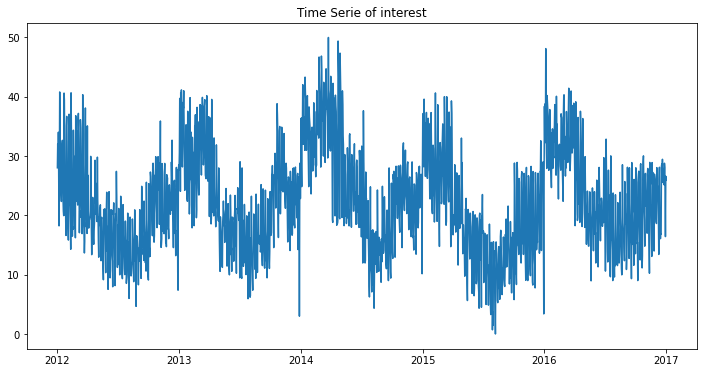

In [14]:
exploring_time_serie(dict_ts_sequence['dataset'], 
                     dict_ts_sequence['date_colname'], 
                     dict_ts_sequence['y_colname'])

This is a monthly time series. We will test and forecast 24 months into the futur.
We can observe that the time series is deterministic. There seems to have a strong positive trend and a strong monthly seasonality.

We will check rapidly the cyclic means to confirm what we observed above:

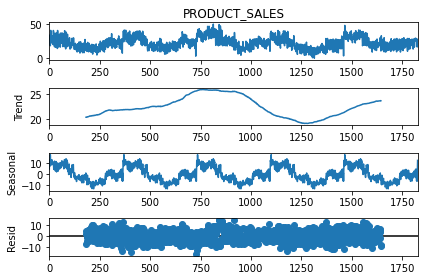

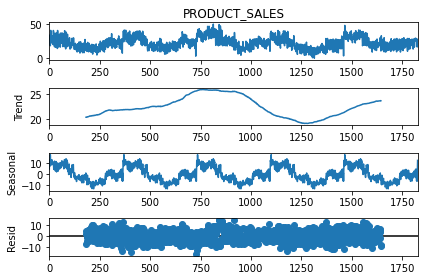

In [15]:
result = seasonal_decompose(ts_sequence[dict_ts_sequence['y_colname']], model='additive', period = dict_ts_sequence['freq'])
result.plot()

<a class="anchor" id="P1"></a>
# Section#2 - Feature Engineering

<a class="anchor" id="section2.1"></a>
### 2.1 - Train-Test Split Scale

We will start by splitting our dataset in Train and Test sets to be sure we do not include any overfitting features in our test set along the way. (Common mistake have seen soooo many times!). For example, we will calculate seasonal means. we HAVE TO get rid of the test set values BEFORE calculating the means or we will overfitting using test data in our train data.

In [16]:
def split_ts_train_test(ts,
                        date_colname,
                        y_colname_list,
                        n_leads):
    
    ts_train = ts.iloc[:-n_leads, :]
    ts_test = ts.iloc[-n_leads:, :]
       
    return ts, ts_train, ts_test

<a class="anchor" id="section2.2"></a>
### 2.2 - Feature Extraction - Seasonal Means

Now, we can calculate our seasonal means features only on the train set (as we are not supposed to know the test set in the feature !)

In [17]:
def seasonal_means_extract(dataset, date_colname, y_colname, n_leads, freq, y_scaler_sequence = None):
    """Calculate the seasonal means of a given time serie

    Args:
        dataset (dataframe): pandas dataframe
        date_colname (str): Name of the date column in the given dataframe
        y_colname (str): Name of the time serie column in the given dataframe
        n_leads (int): number of period to forecast into the futur
        freq (int): frequency, periods of the time series (1=yearly, 12=monthly, 52=weekly, 365=daily)

    Returns:
        list: a list of strings representing the header columns
    """
    keep_cols = list(dataset.columns)
    
    timeserie = dataset[[date_colname, y_colname]].copy()
    if y_scaler_sequence != None:
        timeserie[y_colname] = y_scaler_sequence.inverse_transform(timeserie[[y_colname]]).ravel()
    
    timeserie.index.name = 'index'
    timeserie.index = pd.to_datetime(timeserie[date_colname])
    timeserie.index.name = 'index'
    
    min_year = np.min(timeserie.index.year)
    max_year = np.max(timeserie.index.year) + int(n_leads/freq) + 5

    all_dates = pd.DataFrame(pd.date_range(pd.to_datetime(str(min_year) + '-01-01'),
                  pd.to_datetime(str(max_year) + '-12-31')-timedelta(days=1),freq='d'), columns = ['ds'])

    if freq == 12:

        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter

        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']

        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
    elif freq == 4:    
        timeserie['QUARTER'] = timeserie.index.quarter.astype(str)
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['QUARTER_YEAR'] = timeserie['YEAR'] + '_' + timeserie['QUARTER']

        all_dates['QUARTER'] = all_dates['ds'].dt.quarter.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['QUARTER_YEAR'] = all_dates['YEAR'] + '_' + all_dates['QUARTER']
        all_dates = all_dates.groupby(['QUARTER_YEAR']).size().reset_index()
        all_dates.columns = ['QUARTER_YEAR', 'N_DAYS']
        

        timeserie1 = pd.merge(timeserie, quarter_mean, how = 'left', 
                              left_on = 'QUARTER', right_on = 'QUARTER')
        timeserie1.index = timeserie.index


    elif freq == 52:   
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['WEEK_YEAR'] = timeserie['YEAR'].astype(str) + '_' + timeserie['WEEK'].astype(str)
        #del timeserie['YEAR']

        all_dates['WEEK'] = all_dates['ds'].dt.week.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['WEEK_YEAR'] = all_dates['YEAR'] + '_' + all_dates['WEEK']
        all_dates = all_dates.groupby(['WEEK_YEAR']).size().reset_index()
        all_dates.columns = ['WEEK_YEAR', 'N_DAYS']

        #del timeserie['WEEK_YEAR']


        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
    
    elif freq >= 100 and freq <= 600:    
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH'] = timeserie.index.month
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie = timeserie.fillna(0)
     
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        model_mean = timeserie[['WEEKLY_MONTHLY', y_colname]].groupby(['WEEKLY_MONTHLY']).mean([y_colname]).reset_index()
        model_mean.columns = ['WEEKLY_MONTHLY', 'WEEKLY_MONTHLY_MEAN']
        timeserie = pd.merge(timeserie, model_mean, how = 'left', left_on = 'WEEKLY_MONTHLY', right_on = 'WEEKLY_MONTHLY')
        #del timeserie2['MEAN_MODEL']
    
    timeserie.index = pd.to_datetime(dataset[date_colname])
    
    if y_scaler_sequence != None:
        for col in [col for col in timeserie.columns if '_MEAN' in col]:
            timeserie[col] = y_scaler_sequence.transform(timeserie[[col]]).ravel()
    
    add_cols = list(set(keep_cols) - set(timeserie.columns))
    
    for col in add_cols:
        
        timeserie[col] = dataset[col]

    return timeserie

SEASONALITIES


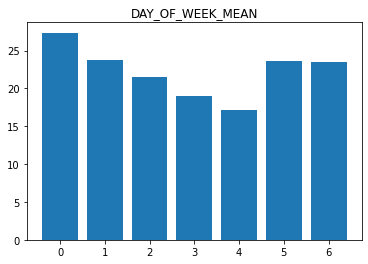

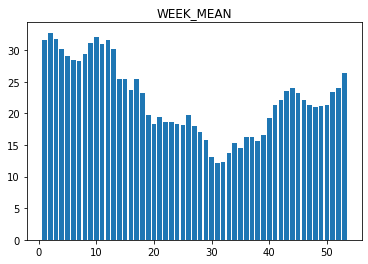

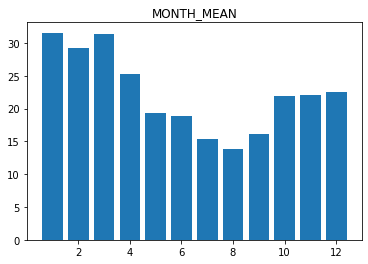

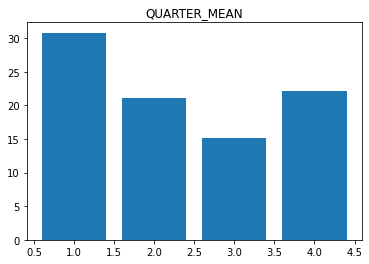

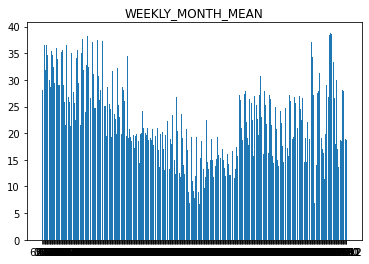

In [18]:
#for key, value in dict_ts.items():
mean_df = seasonal_means_extract(dataset = dict_ts_sequence['dataset'], 
                                 date_colname = dict_ts_sequence['date_colname'], 
                                 y_colname= dict_ts_sequence['y_colname'], 
                                 n_leads= dict_ts_sequence['n_leads'], 
                                 freq= dict_ts_sequence['freq'])
if dict_ts_sequence['freq'] == 12:
    print('SEASONALITIES')
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
else:
    print('SEASONALITIES')
    
    mean_df_distinct = mean_df[['DAY_OF_WEEK','DAY_OF_WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['DAY_OF_WEEK'], mean_df_distinct['DAY_OF_WEEK_MEAN'])
    plt.title('DAY_OF_WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEK','WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEK'], mean_df_distinct['WEEK_MEAN'])
    plt.title('WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEKLY_MONTHLY','WEEKLY_MONTHLY_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEKLY_MONTHLY'], mean_df_distinct['WEEKLY_MONTHLY_MEAN'])
    plt.title('WEEKLY_MONTH_MEAN')
    plt.show()
    

In [19]:
def merge_seasonal_features(dataset, seasonal_features):
    timeserie = dataset.copy()
    
    timeserie.index = pd.to_datetime(timeserie.index)

    timeserie.index.name = 'index'
    
    
    
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['DAY_OF_MONTH'] = timeserie.index.day
    timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
    timeserie['WEEK'] = timeserie.index.week
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
    
    for feat in ['WEEK',
                 'MONTH',
                'QUARTER',
                'DAY_OF_MONTH',
                'DAY_OF_WEEK',
                'WEEKLY_MONTHLY']:
        if feat in seasonal_features.columns:
            seasonal_features_feat = seasonal_features[[feat, feat+'_MEAN']].drop_duplicates().reset_index(drop = True)
            timeserie = pd.merge(timeserie, seasonal_features_feat[[feat, feat+'_MEAN']], how = 'left', left_on = feat, right_on = feat)

            del timeserie[feat]
        else:
            try:
                del timeserie[feat]
            except:
                pass
            pass
    
    for col in timeserie.columns:
        dataset[col] = timeserie[col].values
    
    
    return dataset

<a class="anchor" id="section2.3"></a>
### 2.3 - Feature Extraction - Lagged values

We will then convert our 1D time series into a 2D matrice with X features and y targets. The features will represent actual and lagged values while the targets will represent leaded values. This way, our model will be learning to extrapolate n_leads periods into the futur based on some features (multi-target regression problem).

In [20]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, feat_str_at_end=True, feat_lag_str = 'TM', feat_lead_str = 'TP'):
    
    if feat_str_at_end == True:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          if i < 10:
              name_i = '0' + str(i)
          else:
              name_i = str(i)
              
          names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'') +'_' + feat_lag_str + name_i) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    else:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          names += [(feat_lag_str + '%d' % (i) + str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    return agg

For the sequence time series, we will add 12 lagged value as features (1 year in the past).

Here,"TM" mean "Time Minus", soo it's a lagged n periods feature values of our time series.
Here,"TP" mean "Time Plus", soo it's a leaded n periods target values of our time series (the value we want to forecast into the future).
we juste created a multi-target regression dataframe.

We have to concatenate our seasonal features with our new matrice.

<a class="anchor" id="section2.4"></a>
### 2.4 - Feature Extraction - Fourier terms

In [21]:
def extract_fourier_terms(dataset):
    
    #ts_copy = dataset[[date_colname]]
    dataset['sin365_2'] = np.sin(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['sin365_2'] = StandardScaler().fit_transform(dataset['sin365_2'].values.reshape(-1,1))
    
    dataset['sin365_4'] = np.sin(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['sin365_4'] = StandardScaler().fit_transform(dataset['sin365_4'].values.reshape(-1,1))
    
    dataset['cos365_2'] = np.cos(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['cos365_2'] = StandardScaler().fit_transform(dataset['cos365_2'].values.reshape(-1,1))
    
    dataset['cos365_4'] = np.cos(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['cos365_4'] = StandardScaler().fit_transform(dataset['cos365_4'].values.reshape(-1,1))
    
    dataset['tanh365_2'] = np.tanh(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['tanh365_2'] = StandardScaler().fit_transform(dataset['tanh365_2'].values.reshape(-1,1))
    
    dataset['tanh365_4'] = np.tanh(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['tanh365_4'] = StandardScaler().fit_transform(dataset['tanh365_4'].values.reshape(-1,1))
    
    return dataset

<a class="anchor" id="section2.5"></a>
### 2.5 - Final dataset - Merge all features + Differenciation, Seasonality, Trend

In [22]:
def dataprep_pipeline(ts_data, 
                      dict_ts_sequence, 
                      seasonal_features = True,
                      diff_trend = True,
                      exog = True,
                      fourier_terms = True):
    ####SCALING
    y_scaler_forecast = StandardScaler()
    ts_sequence_forecast = ts_data.copy()
    ts_sequence_forecast

    y_data = ts_sequence_forecast[[dict_ts_sequence['y_colname']]].copy()

    y_data = pd.DataFrame(y_scaler_forecast.fit_transform(y_data))
    y_data.columns = [dict_ts_sequence['y_colname']]
    for y_colname in y_data.columns:
        ts_sequence_forecast[y_colname] = y_data[y_colname].values

    y_colname = dict_ts_sequence['y_colname']
    ###CALCULATE SEASONAL MEANS
    if seasonal_features == True:
        seasonal_list = []
        all_cols = [dict_ts_sequence['date_colname'], dict_ts_sequence['y_colname']]

        ts_sequence_seasonal_feats_full = seasonal_means_extract(dataset = ts_data[all_cols], 
                                                         date_colname = dict_ts_sequence['date_colname'], 
                                                         y_colname= y_colname, 
                                                         n_leads= dict_ts_sequence['n_leads'], 
                                                         freq= dict_ts_sequence['freq'],
                                                          y_scaler_sequence = y_scaler_forecast)
        
        ts_sequence_seasonal_feats_full.index = pd.to_datetime(ts_data[dict_ts_sequence['date_colname']])
        del ts_sequence_seasonal_feats_full[dict_ts_sequence['date_colname']]
        del ts_sequence_seasonal_feats_full[y_colname]

    ts_sequence_forecast.index = pd.to_datetime(ts_sequence_forecast['DATE'])
    

    ts_sequence_supervised_full = series_to_supervised(ts_sequence_forecast[[y_colname]], 
                                              n_in=dict_ts_sequence['n_lags'], 
                                              n_out=1, 
                                              dropnan=True, 
                                              feat_str_at_end=True, 
                                              feat_lag_str = 'TM', 
                                              feat_lead_str = 'TP')
    
    ### MERGE SEASONAL MEANS
    if seasonal_features == True:
        ts_sequence_supervised_full = merge_seasonal_features(dataset = ts_sequence_supervised_full.copy(), 
                                                              seasonal_features = ts_sequence_seasonal_feats_full.copy())
        
        for col in ts_sequence_seasonal_feats_full.columns:
            if col in ts_sequence_supervised_full.columns:
                ts_sequence_supervised_full[col] = StandardScaler().fit_transform(ts_sequence_supervised_full[[col]]).ravel()

    ### DIFF TREND
    if diff_trend == True:

        ts_sequence_supervised_full['DIFF_' + y_colname] = StandardScaler().fit_transform(ts_sequence_supervised_full[y_colname].diff().fillna(0).values.reshape(-1,1))

        decomp = seasonal_decompose(ts_sequence_supervised_full[y_colname], model='additive', period = dict_ts_sequence['freq'], extrapolate_trend=1)
        ts_sequence_supervised_full['TREND_' + y_colname] = StandardScaler().fit_transform(decomp.trend.values.reshape(-1,1))
        #ts_sequence_supervised['SEASON'] = StandardScaler().fit_transform(decomp.seasonal.values.reshape(-1,1))

    ### EXOG
    if exog == True:
        exog_cols = []
        all_cols = [dict_ts_sequence['y_colname'], dict_ts_sequence['date_colname'], 'Date','date']
        for col in ts_sequence.columns.difference(all_cols):
            exog_cols.append(col)

        dict_ts_sequence_exog = ts_sequence[exog_cols]

        exog_scaler = StandardScaler()
        dict_ts_sequence_exog = pd.DataFrame(exog_scaler.fit_transform(dict_ts_sequence_exog),
                                             index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']]),
                                             columns = exog_cols)
        


        for col in dict_ts_sequence_exog.columns:
            ts_sequence_supervised_full = pd.merge(ts_sequence_supervised_full, 
                                                   dict_ts_sequence_exog[[col]],
                                                  how = 'left',
                                                  left_index = True,
                                                  right_index = True)
    
    return ts_sequence_supervised_full, y_scaler_forecast

In [23]:
ts_full, ts_sequence_train, ts_sequence_test = split_ts_train_test(ts = dict_ts_sequence['dataset_orig'].copy(),
                                                  date_colname = dict_ts_sequence['date_colname'],
                                                  y_colname_list = dict_ts_sequence['y_colname'],
                                                  n_leads = dict_ts_sequence['n_leads'])

from ts_transform import TransformerDiff, TransformerLog
diff_transformer_dict_train = {}
diff_transformer_dict_full = {}

log_transformer_dict_train = {}
log_transformer_dict_full = {}

y_colname =  dict_ts_sequence['y_colname']
log_transformer_full = TransformerLog()
diff_transformer_full = TransformerDiff()

if dict_ts_sequence['stabilize_variance'] == True:
    ts_full[y_colname] = log_transformer_full.fit_transform(ts_full[[y_colname]].values)
    log_transformer_dict_full[y_colname] = log_transformer_full
if dict_ts_sequence['stabilize_mean'] == True:
    ts_full[y_colname] = diff_transformer_full.fit_transform(ts_full[[y_colname]].values)
    diff_transformer_dict_full[y_colname] = diff_transformer_full
    
ts_full = ts_full.dropna()

log_transformer = TransformerLog()
diff_transformer = TransformerDiff()
if dict_ts_sequence['stabilize_variance'] == True:
    ts_sequence_train[y_colname] = log_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    log_transformer_dict_train[y_colname] = log_transformer
if dict_ts_sequence['stabilize_mean'] == True:
    ts_sequence_train[y_colname] = diff_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    diff_transformer_dict_train[y_colname] = diff_transformer
        
ts_sequence_train = ts_sequence_train.dropna()


dict_ts_sequence['diff_transformer_dict_full'] = diff_transformer_dict_full
dict_ts_sequence['log_transformer_dict_full'] = log_transformer_dict_full
ts_sequence_supervised_full, y_scaler_forecast = dataprep_pipeline(ts_full.copy(), 
                                                                  dict_ts_sequence, 
                                                                  seasonal_features = dict_ts_sequence['seasonal_features'],
                                                                  diff_trend = dict_ts_sequence['diff_trend'],
                                                                  exog = dict_ts_sequence['exog'],
                                                                  fourier_terms = dict_ts_sequence['fourier_terms'])

dict_ts_sequence['diff_transformer_dict_train'] = diff_transformer_dict_train
dict_ts_sequence['log_transformer_dict_train'] = log_transformer_dict_train
ts_sequence_supervised, y_scaler_sequence = dataprep_pipeline(ts_sequence_train.copy(), 
                                                              dict_ts_sequence, 
                                                              seasonal_features = dict_ts_sequence['seasonal_features'],
                                                              diff_trend = dict_ts_sequence['diff_trend'],
                                                              exog = dict_ts_sequence['exog'],
                                                              fourier_terms = dict_ts_sequence['fourier_terms'])

In [24]:
ts_sequence_supervised.columns
ts_sequence_supervised

,PRODUCT_SALES_TM30,PRODUCT_SALES_TM29,PRODUCT_SALES_TM28,PRODUCT_SALES_TM27,PRODUCT_SALES_TM26,PRODUCT_SALES_TM25,PRODUCT_SALES_TM24,PRODUCT_SALES_TM23,PRODUCT_SALES_TM22,PRODUCT_SALES_TM21,...,PRODUCT_SALES_TM03,PRODUCT_SALES_TM02,PRODUCT_SALES_TM01,PRODUCT_SALES,WEEK_MEAN,MONTH_MEAN,QUARTER_MEAN,DAY_OF_MONTH_MEAN,DAY_OF_WEEK_MEAN,WEEKLY_MONTHLY_MEAN
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-31,0.704731,1.166550,0.740751,1.394769,0.523551,-0.422885,0.978877,2.175466,1.391952,0.658461,...,1.519725,1.702137,0.878829,0.244466,1.068916,1.628974,1.544299,-1.466383,0.417293,0.987103
2012-02-01,1.166550,0.740751,1.394769,0.523551,-0.422885,0.978877,2.175466,1.391952,0.658461,0.412602,...,1.702137,0.878829,0.244466,-0.456893,1.068916,1.201908,1.544299,-0.595216,-0.309477,-0.512833
2012-02-02,0.740751,1.394769,0.523551,-0.422885,0.978877,2.175466,1.391952,0.658461,0.412602,0.185749,...,0.878829,0.244466,-0.456893,-0.448366,1.068916,1.201908,1.544299,1.384884,-1.027313,-0.502745
2012-02-03,1.394769,0.523551,-0.422885,0.978877,2.175466,1.391952,0.658461,0.412602,0.185749,0.050737,...,0.244466,-0.456893,-0.448366,-0.698003,1.068916,1.201908,1.544299,0.535252,-1.653041,-0.393739
2012-02-04,0.523551,-0.422885,0.978877,2.175466,1.391952,0.658461,0.412602,0.185749,0.050737,1.031128,...,-0.456893,-0.448366,-0.698003,1.216658,1.068916,1.201908,1.544299,1.050376,0.543441,1.843137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-28,0.631804,0.458008,-0.236279,-0.666582,-1.068886,-1.182935,-1.626171,0.611706,0.366727,-0.452628,...,0.757028,0.727686,0.395013,0.818345,0.173191,0.079533,0.076908,0.477957,1.551080,0.995997
2015-12-29,0.458008,-0.236279,-0.666582,-1.068886,-1.182935,-1.626171,0.611706,0.366727,-0.452628,-0.886630,...,0.727686,0.395013,0.818345,-0.671057,0.173191,0.079533,0.076908,-0.249176,0.417293,-0.766227
2015-12-30,-0.236279,-0.666582,-1.068886,-1.182935,-1.626171,0.611706,0.366727,-0.452628,-0.886630,-0.867872,...,0.395013,0.818345,-0.671057,-2.130836,0.173191,0.079533,0.076908,-2.173696,-0.309477,-2.493401


<a class="anchor" id="P3"></a>
# Section#3 - From 2D Matrice to 3D Tensor

Now, if we want to convert this matrice in a 3d vector:

In [25]:
def prep_data_3d_arch1(data, y_colname_list, date_colname, n_leads):

    #timeserie = data.copy()
    n_step = n_leads
    

    timeserie = data.copy()
    timeserie = timeserie[timeserie.columns.difference([date_colname])]

    Xtimeserie = timeserie[timeserie.columns.difference([date_colname])]

    ytimeserie = timeserie[y_colname_list]
        
    feats = list(Xtimeserie.columns)
    Xlist = []
    ylist = []

    i = 0
    for i in range(0, len(timeserie) - ((n_step*2)-1)):
        #print(i)
        Xlist.append([Xtimeserie.iloc[i: i+n_step].values])
        ylist.append([ytimeserie.iloc[i+n_step: i+(n_step*2)][y_colname_list].values])
    
    Xlist_T = np.array(Xlist).reshape(len(Xtimeserie) - ((n_step*2)-1), n_step, len(Xtimeserie.columns))
    ylist_T = np.array(ylist).reshape(len(ytimeserie) - ((n_step*2)-1), n_step, len(y_colname_list))


    XlistTest = []
    i = 0
    for i in range(len(Xtimeserie) - n_step, len(Xtimeserie)- (n_step-1)):
        XlistTest.append([Xtimeserie.iloc[i: i+n_step].values])
    XlistTest_T = np.array(XlistTest).reshape(1, n_step, len(Xtimeserie.columns))

    Xlist_T_all = Xlist_T.copy()
    ylist_T_all = ylist_T.copy()
    XlistTest_T_all = XlistTest_T.copy()

    return Xlist_T_all, ylist_T_all, XlistTest_T_all, feats

In [26]:
X_train_sequence, y_train_sequence, X_test_sequence, feats = prep_data_3d_arch1(data = ts_sequence_supervised.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])
print(X_train_sequence.shape, y_train_sequence.shape)

(703, 365, 37) (703, 365, 1)


<a class="anchor" id="section3.1"></a>
### 3.1 - 3D Train-Test set

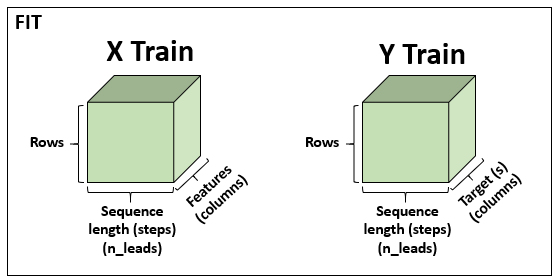

In [27]:
Image(filename='/opt/continuum/data/image/3DTensor-Fit.png')

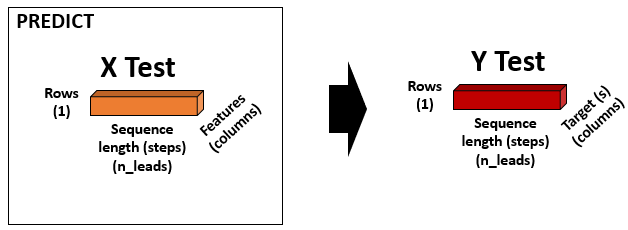

In [28]:
Image(filename='/opt/continuum/data/image/3DTensor-Predict.png')

In [29]:
X_train_sequence, y_train_sequence, X_test_sequence, feats = prep_data_3d_arch1(data = ts_sequence_supervised.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

print(X_train_sequence.shape, y_train_sequence.shape)

#y_test is just the last Y sequence of n_leads form the original time serie

(703, 365, 37) (703, 365, 1)


In [30]:
print(X_train_sequence.shape, y_train_sequence.shape)

dict_explain_tensor = {}
ijk = 0 
for val in X_train_sequence.shape:
    if ijk == 0:
        dict_explain_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_tensor[val])
    ijk = ijk + 1

(703, 365, 37) (703, 365, 1)
703 Number of rows (Time occurences)
365 Sequence length - Number of steps to forecasts (n_leads)
37 Number of columns (Features)


In [31]:
print(X_test_sequence.shape)

(1, 365, 37)


<a class="anchor" id="section3.2"></a>
### 3.2 - 3D Forecast set

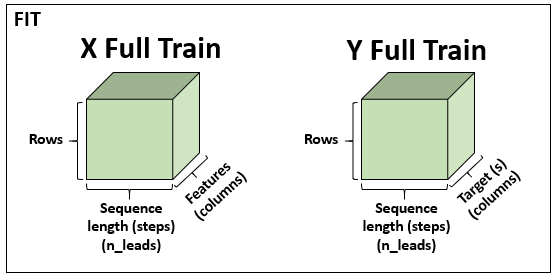

In [32]:
Image(filename='/opt/continuum/data/image/3DTensor-FullFit.png')

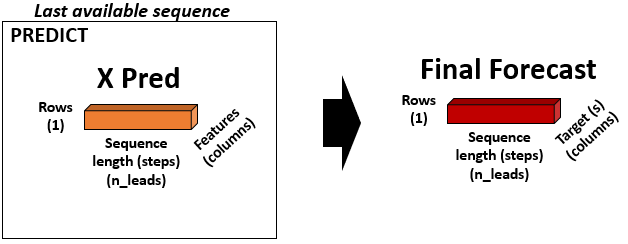

In [33]:
Image(filename='/opt/continuum/data/image/3DTensor-Forecast.png')

In [34]:
X_train_full, y_train_full, X_forecast, feats = prep_data_3d_arch1(data = ts_sequence_supervised_full.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

In [35]:
print(X_train_full.shape, y_train_full.shape)
dict_explain_full_tensor = {}
ijk = 0 
for val in X_train_full.shape:
    if ijk == 0:
        dict_explain_full_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_full_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_full_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_full_tensor[val])
    ijk = ijk + 1

(1068, 365, 37) (1068, 365, 1)
1068 Number of rows (Time occurences)
365 Sequence length - Number of steps to forecasts (n_leads)
37 Number of columns (Features)


<a class="anchor" id="P4"></a>
# Section#4 - RdR Score Performance Metric

The proposed RdR metric use: <br>
R: Naïve Random Walk <br>
d: Dynamic Time Warping <br>
R: Root Mean Squared Error <br>

The proposed RdR score technic will mainly answer three questions: <br>
#1 How can we take into account the shape similarity of a time series? : <br>
Answer: Dynamic Time Warping <br>

#2 How can we know if we should use our forecasting model or not? : <br>
Answer: Is it better or worst than a Naïve Random Walk? How Much ? (Well... also depends on your business goals here !) <br>

#3 How can we take into account the errors? : <br>
Answer: Root Mean Squared Error (RMSE) <br> 

0 = Performance same as a random walk model <br>
1 = Performance is perfect <br>
< 0 = Performance is worst than a random walk model <br>

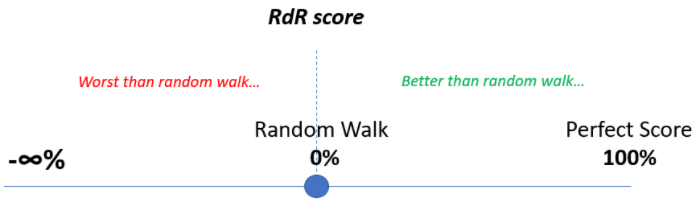

In [36]:
Image(filename='/opt/continuum/data/image/RdRScore.png')

If you want a better explaination of the RdR Score, follow the link bellow:

%%html
<a href="https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7">Click Me --> RdR Score on Medium</a>

In [37]:

scorer_benchmark = RdR_scorer()

<a class="anchor" id="P5"></a>
# Section#5 - BiLSTM

In [38]:
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('.', end='')

<a class="anchor" id="section5.1"></a>
### 5.1 - BiLSTM Architecture

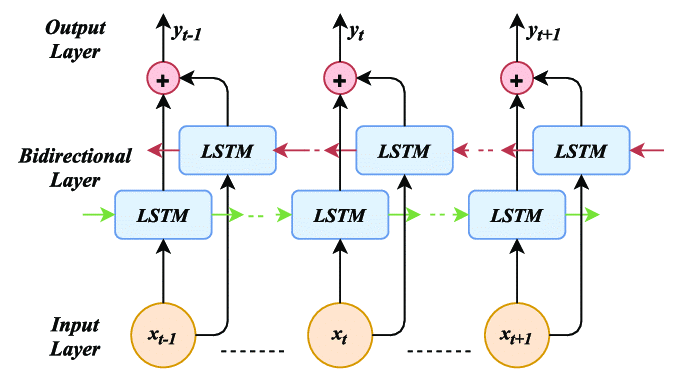

In [39]:
Image(filename='/opt/continuum/data/image/blstm.png')

In [40]:
input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def create_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim, 
                                   return_sequences=False, 
                                   kernel_initializer = 'glorot_uniform',
                                   activation = 'tanh'
                                   )))
    model.add(Dense(units=output_dim, activation = 'linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)#, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    
    return model

model = create_BiLSTM()



2022-04-04 20:17:09.502299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-04 20:17:09.502341: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-04 20:17:09.502372: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anaconda-session-0642e1b2ba064820b8320b76c6599e10-d47fd44cfjfbq): /proc/driver/nvidia/version does not exist
2022-04-04 20:17:09.502660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

<a class="anchor" id="section5.2"></a>
### 5.2 - BiLSTM Train

In [41]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=10)#4
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 60, 
                    validation_data = (X_train_full[-dict_ts_sequence['n_leads']:,:, :], 
                                       y_train_full[-dict_ts_sequence['n_leads']:,:, :]),
                    #validation_split = 0.1, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])



.

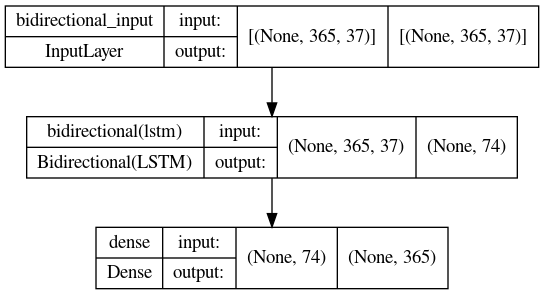

In [42]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [43]:
def plot_learning_curve(history, monitor_label = 'val_loss'):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    min_vec = []
    for i in range(0, len(hist)):
        if i == 0:
            min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
        else:
            if hist[[monitor_label]].iloc[i, :].values[0] < np.min(min_vec):
                min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
            else:
                min_vec.append(np.min(min_vec))

    hist['best_from_start'] = min_vec
    hist['improved'] = np.where(hist['best_from_start'] == hist[monitor_label], 1, 0)
            

    best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]

    plt.figure(figsize = (18, 9))
    plt.plot(hist[monitor_label], label = monitor_label)
    try:
        plt.plot(hist['loss'], label = 'loss')
    except:
        pass
    #plt.plot(hist[monitor_label], label = 'val_loss')

    plt.scatter(hist[hist['improved'] == 1]['epoch'], hist[hist['improved'] == 1][monitor_label], color = 'green', label = 'Improved')
    plt.legend()
    plt.title('Learning curve'
              '\n' + 'best epoch:' + str(best_epoch) + '(' + str(round(np.min(hist[monitor_label]), 3)) + ')')

max epoch : 21


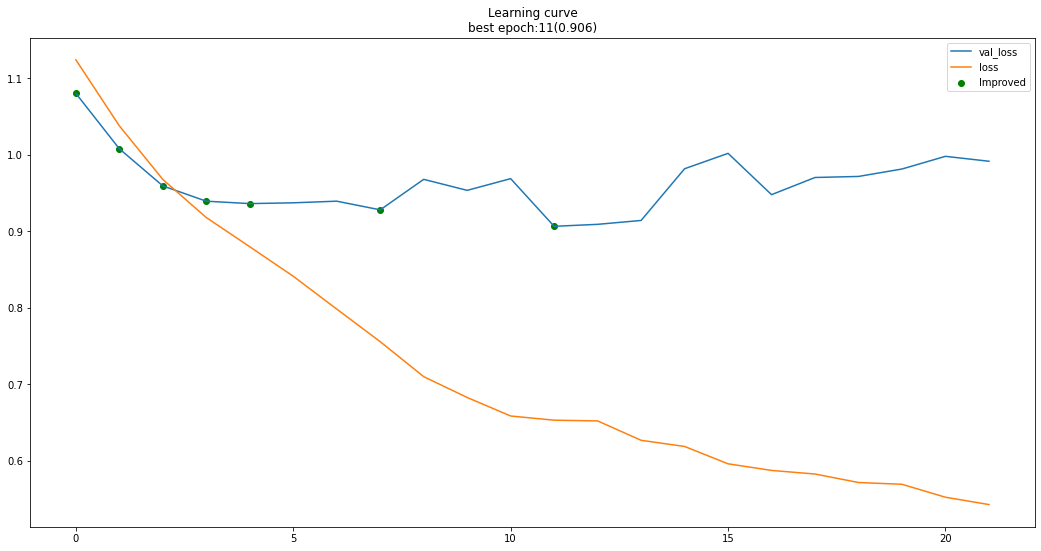

In [44]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section5.3"></a>
### 5.3 - BiLSTM Validation

In [45]:
pred_all = pd.DataFrame(model.predict(X_test_sequence)).T
#pred_scaled = pd.DataFrame(np.mean(model.predict(X_test_sequence), axis = 0))
#pred_scaled = np.mean(pred_scaled, axis = 1)
#pred_all

In [46]:
def inverse_forecast(y_scaler, dict_ts, pred_df):
    pred_df = pd.DataFrame(y_scaler.inverse_transform(pred_df))
    pred_df.columns = ['Y_PRED']
    
    if dict_ts_sequence['stabilize_mean'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['diff_transformer_dict_train'][dict_ts['y_colname']].forecast_transform(pred_df[['Y_PRED']].values)
    if dict_ts_sequence['stabilize_variance'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['log_transformer_dict_train'][dict_ts['y_colname']].inverse_transform(pred_df[['Y_PRED']].values)
 
    return pred_df

In [47]:
def get_feat_for_scoring(ts, y_scaler, dict_ts, pred_df, model_name):
    
    ts_orig = y_scaler.inverse_transform(ts[dict_ts['y_colname']].values.reshape(-1,1))
    ts_orig = pd.DataFrame(ts_orig, index = ts.index, columns = [dict_ts['y_colname']])
    
    pred_df = inverse_forecast(y_scaler, dict_ts, pred_df)

    y_colname = dict_ts['y_colname']
    n_steps = dict_ts['n_leads']

    #y_true = y_scaler.inverse_transform(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values.reshape(-1,1))   
    y_true = ts.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values.reshape(-1,1)
    y_true = pd.DataFrame(y_true, index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = [dict_ts['y_colname']])
    
    y_pred = pred_df.copy()
    y_pred = pd.DataFrame(y_pred.values.ravel(), index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = ['Y_PRED'])

    freq = dict_ts['freq']    
  
    return ts, y_colname, n_steps, y_true, y_pred, model_name, freq

In [48]:
ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'BiLSTM')


average_ensemble_model = []
average_ensemble_model.append(y_pred)

In [49]:
scorer_benchmark.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

1970-01-02 00:00:00.000001826 1971-01-01 00:00:00.000001826
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25545D+00    |proj g|=  8.68468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.557D-06   3.255D+00
  F =   3.2554529138590027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [50]:
scorer_benchmark.get_df_viz()

,DTW,RMSE,RdR_SCORE,MODEL_NAME
0,85.849541,5.657640,0.36488,BiLSTM
1,152.678808,7.991574,0.00000,RandomWalk


In [51]:
scorer_benchmark.get_rdr_interpretation()

'AVERAGE PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 36.49% better than a naïve random decision. The mean forecast accuracy is 73.07% (around 36.83% and 88.24% of accuracy per forecasted datapoint)'

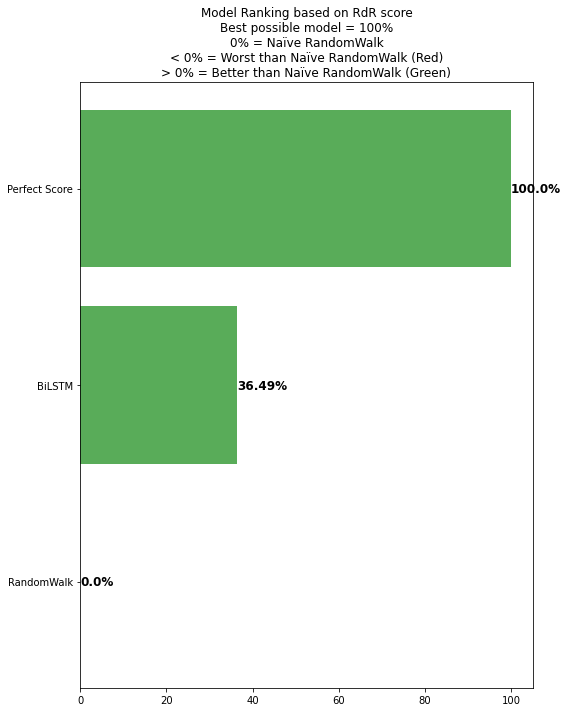

In [52]:
scorer_benchmark.plot_rdr_rank()

In [53]:
def get_pred_dates(freq, X_pred, date_colname, n_leads):
    #ts_sequence_train.index = pd.to_datetime(ts_sequence_train[date_colname])
    if freq == 12:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
    
    elif freq == 52:
        print(X_pred.index)
        print(max(X_pred.index))
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(weeks=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(weeks=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 4:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=3)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i*3) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
    
    elif freq == 2:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=6)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i*6) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 1:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(years=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq >= 250 and freq <= 368:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(days=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(days=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 1638:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=60)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*60) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 3276:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=30) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*30) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
    
    elif freq == 6552:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=15) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*15)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 9828:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=10)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*10)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 19656:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=5)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*5)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 98280:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=1)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    return X_pred_date

In [54]:
def plot_results(ts_train, ts_full, pred_df, y_scaler, forecast, y_scaler_forecast, dict_ts):

    fig, ax = plt.subplots(figsize = (12,8))
    #ax.plot(pd.to_datetime(ts_train.index), 
            #ts_train[dict_ts['y_colname']].values.reshape(-1,1))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),  
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
            pred_df.values.ravel(), label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    plt.title('Validation: True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
        pred_df.values.ravel())
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
        ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values)
    plt.title('Validation (Zoomed): True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    #ax.plot(pd.to_datetime(ts_train.index), 
            #ts_train[dict_ts['y_colname']].values.reshape(-1,1))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),  
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label = 'HISTORICAL')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
            pred_df.values.ravel(), label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    ax.plot(forecast.index, 
            forecast['Y_PRED'].values.ravel(), label = 'FORECAST')
    plt.title('MultiStep Forecast - ' + model_name)
    plt.legend()


<a class="anchor" id="section5.4"></a>
### 5.4 - BiLSTM Forecast

In [55]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=100)#4


model = create_BiLSTM()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch*2, 
                    batch_size = 100, 
                    #validation_data=(X_test, Y_test)
                    #validation_split = 0.1, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(X_forecast))
pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())


pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

ts_sequence_train.index = pd.to_datetime(ts_sequence_train[dict_ts_sequence['date_colname']])
ts_sequence.index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']])

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast = []
average_ensemble_model_forecast.append(pred_forecast)

.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


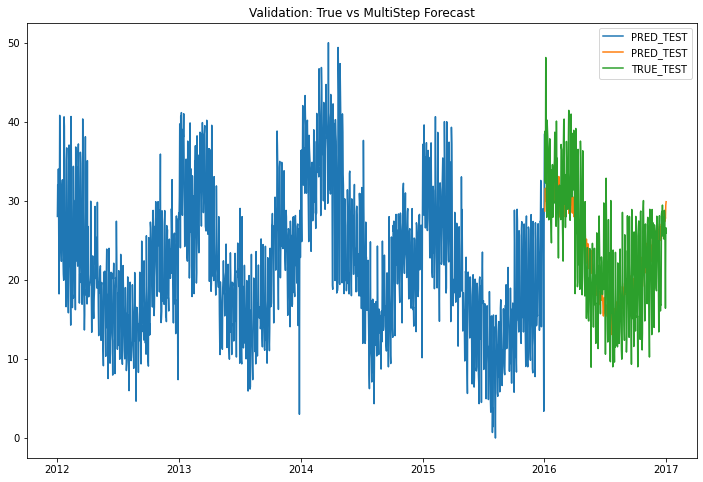

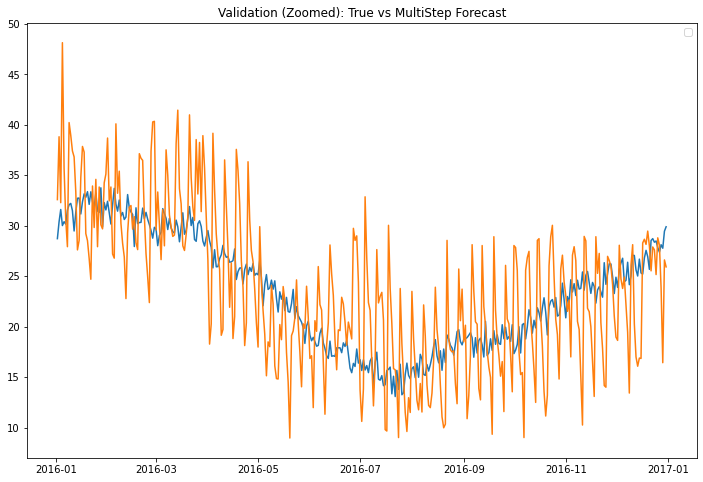

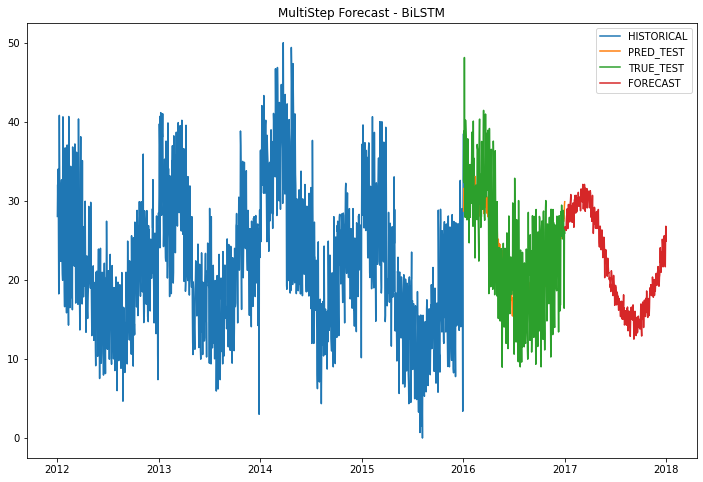

In [56]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

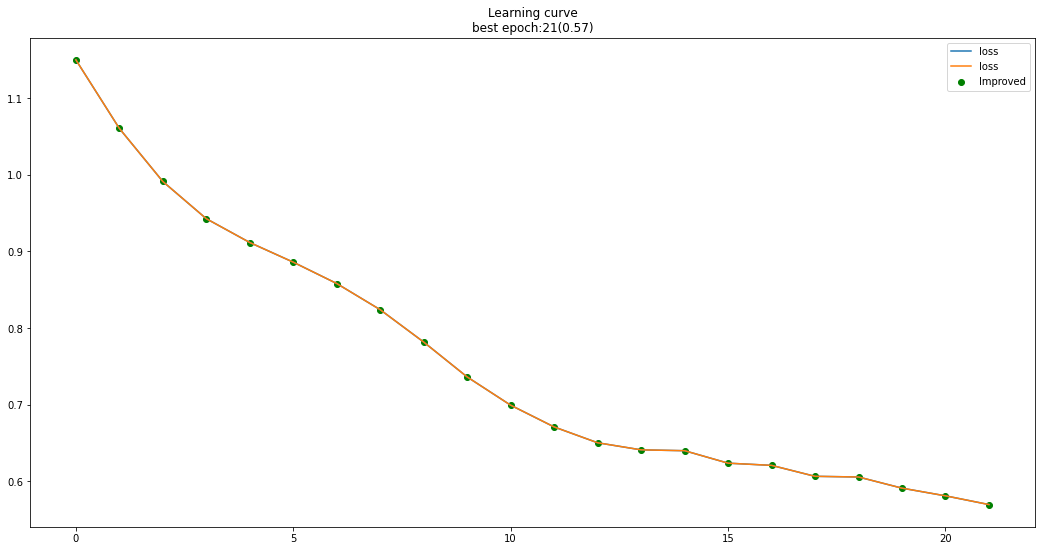

In [57]:
plot_learning_curve(history, monitor_label = 'loss')

<a class="anchor" id="P6"></a>
# Section#6 - Time2Vec-BiLSTM

<a class="anchor" id="section6.1"></a>
### 6.1 - Time2Vec-BiLSTM Architecture

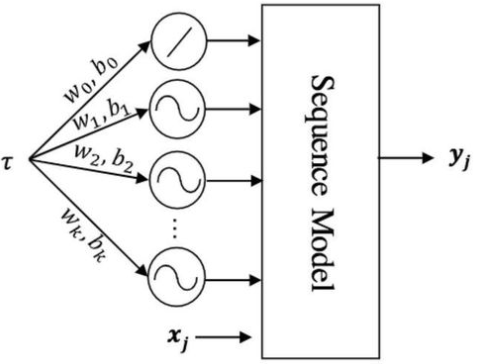

In [58]:
Image(filename='/opt/continuum/data/image/t2v.png')

In [59]:
class Time2Vec(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [60]:
def create_t2v_bilstm():
    inp = Input(shape=(X_train_sequence.shape[1],
                   X_train_sequence.shape[2]))
    x = Time2Vec(120)(inp)
    x = Bidirectional(LSTM(48, activation='tanh', return_sequences = True))(x)
    x = Dense(y_train_sequence.shape[1])(x)

    model = Model(inp, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model
    
model = create_t2v_bilstm()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 365, 37)]         0         
                                                                 
 time2_vec (Time2Vec)        (None, 365, 157)          48970     
                                                                 
 bidirectional_2 (Bidirectio  (None, 365, 96)          79104     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 365, 365)          35405     
                                                                 
Total params: 163,479
Trainable params: 163,479
Non-trainable params: 0
_________________________________________________________________


<a class="anchor" id="section6.2"></a>
### 6.2 - Time2Vec-BiLSTM Train

In [61]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

.

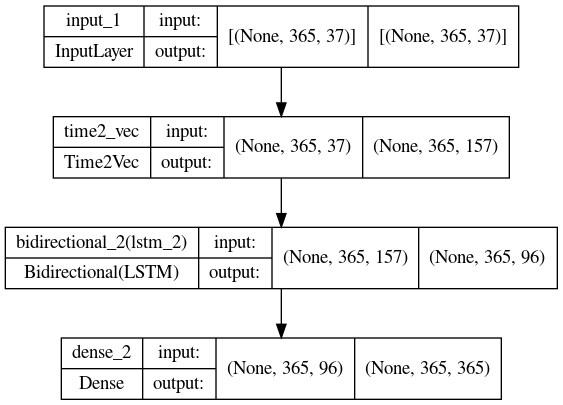

In [62]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 68


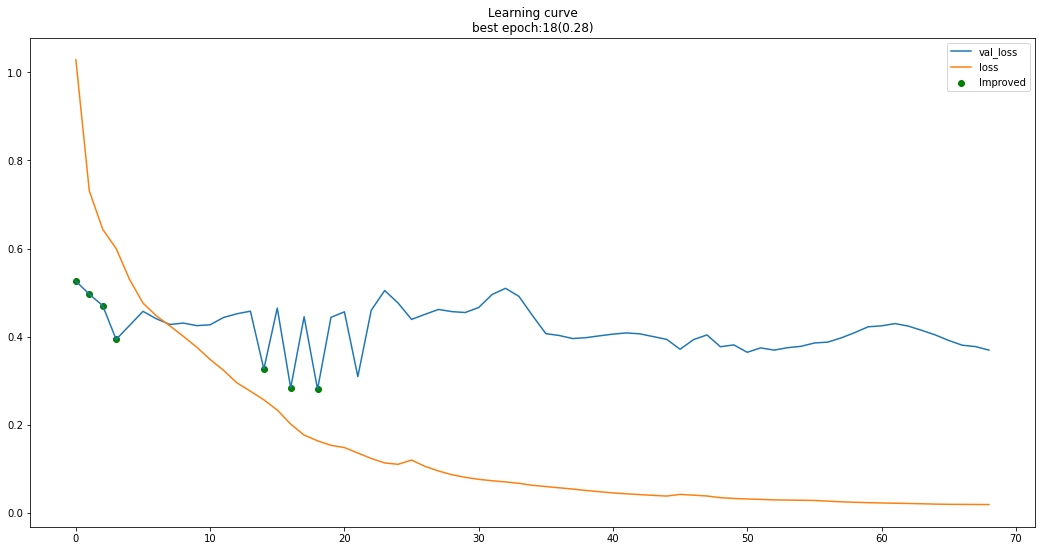

In [63]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section6.3"></a>
### 6.3 - Time2Vec-BiLSTM Validation

In [64]:
pred_all = pd.DataFrame(model.predict(X_forecast)[0,:].T)
pred_all = pd.DataFrame(np.mean(pred_all.T, axis = 1))
pred_all.columns = ['Y_PRED']

In [65]:
scorer_t2vbilstm = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Time2Vec-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_t2vbilstm.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_t2vbilstm.score())
scorer_benchmark.add_rdr(scorer_t2vbilstm)

2017-01-01 00:00:00 2017-12-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25545D+00    |proj g|=  8.68468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.557D-06   3.255D+00
  F =   3.2554529138590027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.4237813360273215


,DTW,RMSE,RdR_SCORE,MODEL_NAME
0,85.849541,5.657640,0.364880,BiLSTM
1,152.678808,7.991574,0.000000,RandomWalk
2,56.628117,6.245737,0.423781,Time2Vec-BiLSTM


In [66]:
scorer_benchmark.get_rdr_interpretation()

'AVERAGE PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 36.49% better than a naïve random decision. The mean forecast accuracy is 73.07% (around 36.83% and 88.24% of accuracy per forecasted datapoint)'

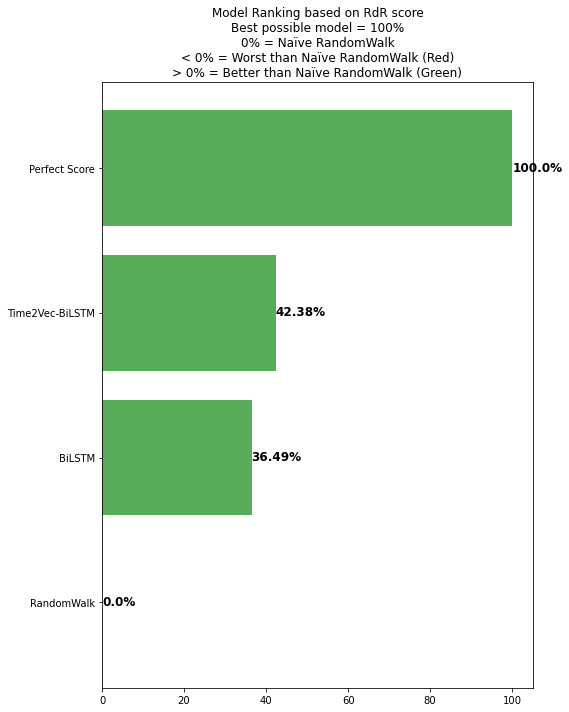

In [67]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section6.4"></a>
### 6.4 - Time2Vec-BiLSTM Forecast

In [68]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)

model = create_t2v_bilstm()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 24, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = pd.DataFrame(np.mean(model.predict(X_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast



X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 365, 37)]         0         
                                                                 
 time2_vec_1 (Time2Vec)      (None, 365, 157)          48970     
                                                                 
 bidirectional_3 (Bidirectio  (None, 365, 96)          79104     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 365, 365)          35405     
                                                                 
Total params: 163,479
Trainable params: 163,479
Non-trainable params: 0
_________________________________________________________________
.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


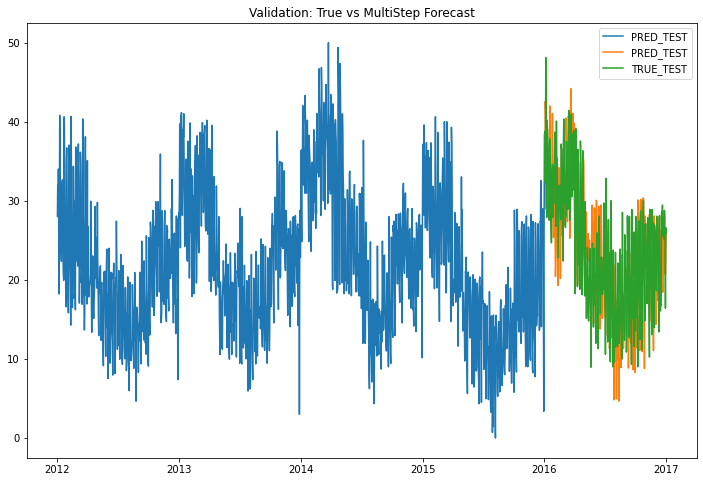

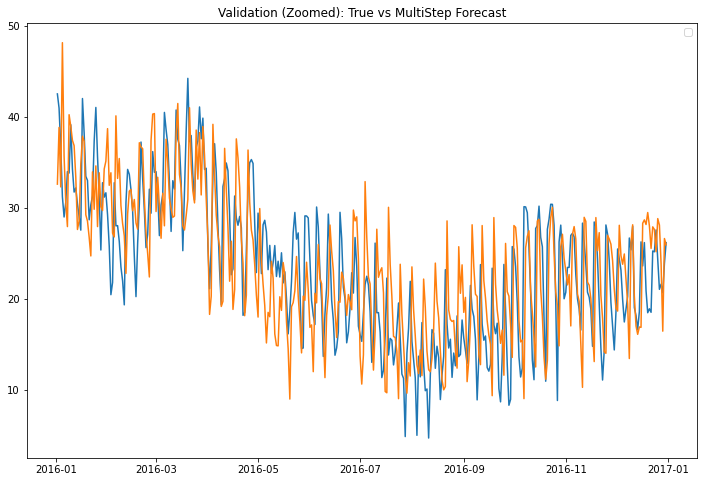

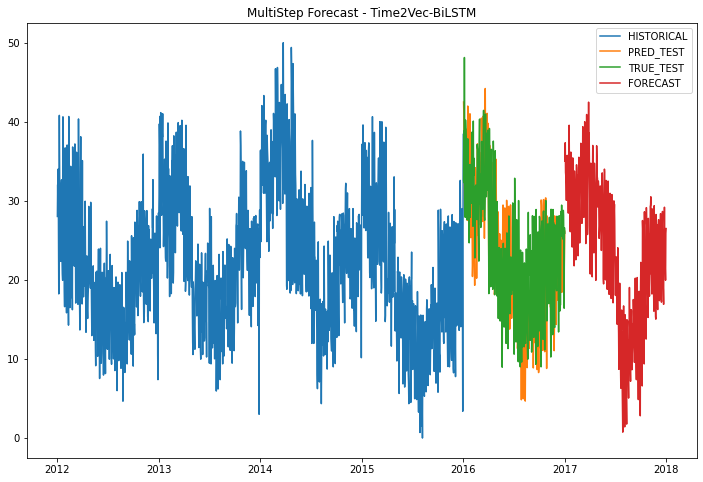

In [69]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

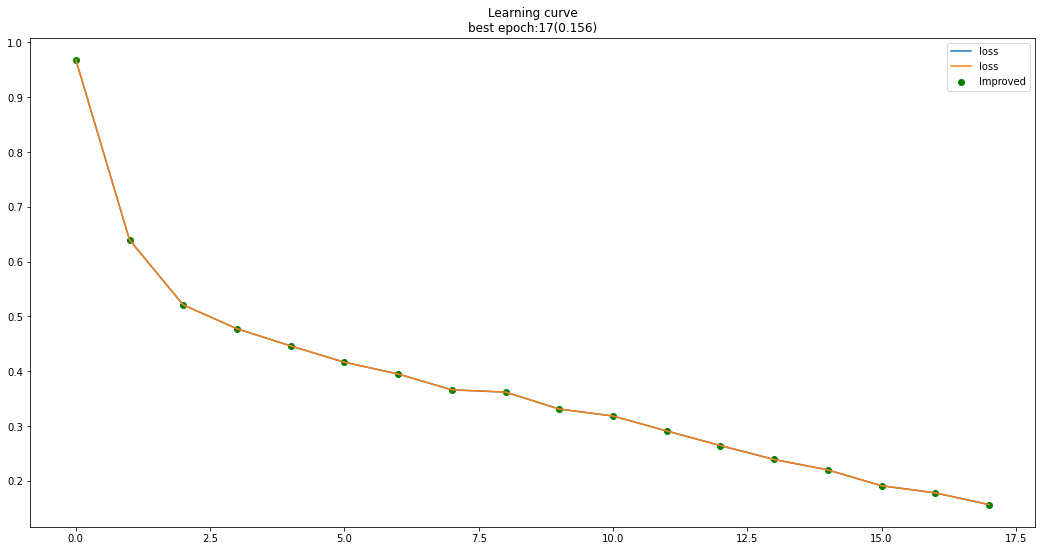

In [70]:
plot_learning_curve(history, 'loss')